In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import torch
from torch.utils.data import Dataset
import os
from glob import glob
from PIL import Image
import cv2
import random
import matplotlib.pyplot as plt
import json
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [4]:
def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

In [58]:


image_transform = A.Compose([
    A.CenterCrop(224, 224),
    A.MotionBlur(p=1.0),
    # A.RandomScale(scale_limit=(-0.4, -0.1), p=1),
    A.HorizontalFlip(p=0.5),
])

background_transform = A.Compose([
    A.RandomResizedCrop(224, 224, ratio=(1,1)),
    A.HueSaturationValue(always_apply=False, p=1.0, hue_shift_limit=(-20, 20), sat_shift_limit=(-30, 30), val_shift_limit=(-20, 20)),
    A.HorizontalFlip(p=0.5),
])


In [59]:
class CustomDataset(Dataset):
    
    def __init__(self, root, train, image_transform, background_transform):
        
        self.root = root
        self.image_transform = image_transform
        self.background_transform = background_transform
        self.normalize = A.Normalize()
        self.toTensor = ToTensorV2()
        self.split = 'train' if train else 'valid'
        
        # images and labels
        self.classes = os.listdir(os.path.join(root, 'image', self.split))
        self.jsons = []
        self.labels = []
           
        for i, _class in enumerate(self.classes):
            _jsons = listdir_fullpath(os.path.join(root, 'label', self.split, _class))
            self.jsons += _jsons
            self.labels += [i] * len(_jsons)
            
        # background images
        self.backgrounds = [cv2.imread(img, cv2.IMREAD_COLOR) for img in listdir_fullpath(os.path.join(root, 'background'))]
        self.backgrounds = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in self.backgrounds]
        
    def __len__(self):
        return len(self.labels) + int(0.25*len(self.labels))
    
    def __getitem__(self, idx):
        
        try:
            
            if 0 <= idx < len(self.labels):

                json_path = self.jsons[idx]
                label = self.labels[idx]

                with open(json_path, 'r') as f:
                    label_info = json.load(f)['label_info']

                #background = self.backgrounds[np.random.choice(len(self.backgrounds))]
                #background = self.background_transform(image=background)['image'].copy()

                image = Image.open(os.path.join(self.root, 'image', self.split, self.classes[label], label_info['image']['file_name']))
                image = np.array(image)
                mask = np.array(label_info['shapes'][0]['points'], dtype=np.int32) // 2

                left, top = np.min(mask, axis=0)
                right, bottom = np.max(mask, axis=0)
                image = image[top:bottom, left:right]

                #mask -= np.min(mask, axis=0)
                #empty_array = np.zeros((bottom-top, right-left, 3), np.uint8)
                #mask = cv2.fillPoly(empty_array, [mask], (1,1,1))

                transformed = self.image_transform(image=image)['image']#, mask=mask)
                #image, mask = transformed['image'], transformed['mask']

                #image = mask * image
        #         h, w = image.shape[:2]
        #         x = np.random.randint(5, 220-5-h)
        #         y = np.random.randint(5, 220-5-w)

        #         background[x:x+h, y:y+w] = cv2.bitwise_and(background[x:x+h, y:y+w], background[x:x+h, y:y+w], mask=(1-mask)) \
        #                                  + cv2.bitwise_and(image, image, mask=mask)

                image = self.normalize(image=transformed)['image']
                image = self.toTensor(image=image)['image']

                return image, label
            
            else:
                
                image = self.backgrounds[idx % len(self.backgrounds)]
                image = self.background_transform(image=image)['image'].copy()
                image = self.normalize(image=image)['image']
                image = self.toTensor(image=image)['image']
                
                return image, len(self.classes)
        
        except:
            return self.__getitem__(idx-1)

In [62]:
dataset = CustomDataset('data', True, image_transform, background_transform)

In [61]:
from dataset import get_crop_train_dataset, get_crop_valid_dataset

dataset = get_crop_valid_dataset()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '(224, 224)  4')

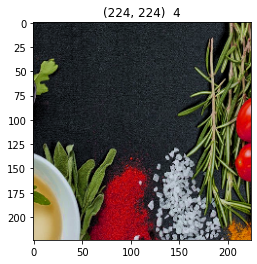

In [87]:
img, label = dataset[-1]

img = img.numpy()
img = img.transpose(1,2,0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
plt.imshow(img)
plt.title(f'{img.shape[:2]}  ' + str(label))

In [718]:
glob('data/label/train/one/*')[0]

'data/label/train/one/QC_cow_segmentation_1_044716.json'

In [14]:
os.path.join('sdfsd', '*')

'sdfsd/*'

In [11]:
import json

In [34]:
list(x['label_info'].keys())

['image', 'shapes']

In [13]:
with open('data/label/train/one/QC_cow_segmentation_1_044716.json', 'r') as f:
    x = json.load(f)

x

{'label_info': {'image': {'file_name': 'QC_cow_segmentation_1_044716.jpg',
   'width': 1080,
   'height': 1920},
  'shapes': [{'label': 'hanwoo',
    'points': [[614.2382271468143, 946.7036011080331],
     [608.6980609418282, 941.1634349030469],
     [603.1578947368421, 935.6232686980608],
     [592.0775623268697, 919.0027700831024],
     [578.2271468144044, 896.8421052631578],
     [567.1468144044321, 880.2216066481993],
     [553.2963988919668, 855.2908587257616],
     [536.6759002770083, 827.5900277008309],
     [520.0554016620498, 802.6592797783933],
     [503.4349030470914, 783.2686980609417],
     [500.6648199445983, 769.4182825484763],
     [497.8947368421052, 750.0277008310248],
     [497.8947368421052, 725.0969529085871],
     [497.8947368421052, 702.9362880886425],
     [497.8947368421052, 680.7756232686979],
     [495.12465373961214, 664.1551246537396],
     [486.8144044321329, 641.994459833795],
     [472.96398891966754, 625.3739612188365],
     [456.3434903047091, 619.8337